### Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rc('image', cmap='RdBu_r')

In [2]:
import glob
import random
import itertools as it
from collections import defaultdict
import yaml
import dill as pkl
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import seaborn
import matplotlib.pyplot as plt

from data.dataset import GraphDataset, GraphDataModule
from model.layers import Attention, MLP
from model.model_module import GraphModelModule
import utils.analysis, utils.load, utils.plot

import wandb
import torch
import torch.nn.functional as F
from einops import rearrange, repeat

In [3]:
api = wandb.Api(timeout=19)
PROJECT = 'effie-li/graph-subgoal-v4'
runs, config_list, id_list = utils.load.fetch_runs(api, PROJECT)

def get_config(runid):
    return config_list[id_list.index(runid)]

### load model and val batch

In [4]:
runid = '2w5wl65b'
config = get_config(runid)
root = config['wandb']['save_dir'] + config['wandb']['project']
ckpt = 'last'
val_batch = 'len4+' # 'len4+' or 'all'

model, datamodule, batch = utils.load.load_model_and_val_batch(config=config, ckpt_dir=f'{root}/{runid}/checkpoints', ckpt=ckpt, val_batch=val_batch)
batch_metadata = utils.analysis.generate_batch_metadata(dm=datamodule, batch=batch)
x = utils.analysis.run_model_over_batch(batch, model, config['model']['type'], datamodule.dataset.raw_data['shortest_path'])
correct, pred_paths, closest_target, attn_weights, token_reps = x
batch['shortest_path'] = closest_target

In [5]:
batch.keys()

dict_keys(['index', 'graph_num', 'isomorph_num', 'graph_context', 'edges', 'start_goal_probe', 'path_len', 'shortest_path'])

### token representations

#### \< graph\> \< node\> two-token sequences

In [4]:
# try creating mini_seq batches of [graph token][node token] into the model forward flow
# can we find connectivity information in the contextualized token representation?

def custom_forward(graph_embed, node_embed, model, model_type):
    mini_seq = torch.stack([graph_embed, node_embed], dim=1) # (n, 2, embed_dim)
    with torch.no_grad():
        mask = repeat(torch.tril(torch.ones((2,2))).bool(), 'i j -> b i j', b=len(graph_embed)) if model_type == 'autoreg' else None
        x, attn_weights, token_reps = model.transformer._encoder_forward(mini_seq, attn_mask=mask, return_attn=True, return_reps=True)
        x = model.transformer.out(x)
        if model_type == 'autoreg': x = x[..., 2:] # skip eos units
    return x[:, -1], attn_weights, torch.cat([mini_seq.unsqueeze(1), token_reps], dim=1) # take logits from the node probe token

def construct_graph_connectivity_probe_data(graph_ids, n_isomorph, node_tokens, raw_data):
    # constructs and returns a batch where each node in each graph is paired with all other nodes and 
    # the connectivity information is stored in the target labels

    batch = {'graph_context_id':[], 'node':[], 'pair_node':[], 'is_neighbor':[]}
    for g in graph_ids:
        for iso in range(n_isomorph):
            graph_context_id = graph_ids.index(g) * n_isomorph + iso
            i = np.where((np.array(raw_data['graph_num']) == g) & (np.array(raw_data['isomorph_num']) == iso))[0][0]
            edges = raw_data['edge_list'][i]
            batch['graph_context_id'].extend([graph_context_id] * len(node_tokens))

            for node in node_tokens:
                batch['node'].append(node)
                batch['pair_node'].append(node_tokens.tolist())
                is_neighbor = [((node, neighbor) in edges or (neighbor, node) in edges) for neighbor in node_tokens.tolist()]
                batch['is_neighbor'].append(is_neighbor)
    
    return batch

def graph_connectivity_probe_test(runid):

    config = get_config(runid)
    root = config['wandb']['save_dir'] + config['wandb']['project']
    model, datamodule, batch = utils.load.load_model_and_val_batch(config=config, ckpt_dir=f'{root}/{runid}/checkpoints', ckpt='last', val_batch='len4+')
    node_tokens = torch.tensor(list(range(config['dataset']['n_node'])))
    raw_data = datamodule.dataset.raw_data

    probe_batch = construct_graph_connectivity_probe_data(datamodule.dataset.include_graphs, datamodule.dataset.n_isomorph, node_tokens, raw_data)
    result = {'graph_context_id': np.repeat(probe_batch['graph_context_id'], len(node_tokens)),
              'node': np.repeat(probe_batch['node'], len(node_tokens)),
              'pair_node': np.array(probe_batch['pair_node']).flatten(),
              'is_neighbor': np.array(probe_batch['is_neighbor']).flatten()
             }
    with torch.no_grad():
        graph_embed = model.transformer.graph_context_token(torch.tensor(probe_batch['graph_context_id']))
        zero_embed = torch.zeros(len(probe_batch['graph_context_id']), config['model']['embed_dim'])
        random_embed = model.transformer.graph_context_token(torch.randint(0, model.transformer.graph_context_token.num_embeddings, 
                                                                        size=(len(probe_batch['graph_context_id']),)))
        node_embed = model.transformer.node_embeddings(torch.tensor(probe_batch['node']))
    actual_token_reps = None
    for key, embed in zip(['graph_embed', 'zero_embed', 'random_embed'], [graph_embed, zero_embed, random_embed]):
        logits, attn_weights, token_reps = custom_forward(embed, node_embed, model, config['model']['type'])
        if key == 'graph_embed': actual_token_reps = token_reps
        result[f'{key}_logits'] = logits.flatten().tolist()
        logits_sorted = np.sort(logits.numpy(), axis=1) # sorted from small to large, shape (n_graph_context x n_node, n_node)
        result[f'{key}_logit_is_topn'] = [
            x >= logits_sorted[i, -sum(probe_batch['is_neighbor'][i])] 
            for i, seq_logits in enumerate(logits)
            for x in seq_logits.numpy()
        ]

    result = pd.DataFrame(result)
    return config, model, probe_batch, result, actual_token_reps

In [5]:
config, model, probe_batch, df, actual_token_reps = graph_connectivity_probe_test('2w5wl65b')

#### does the graph embedding encode graph connectivity?

0.8487728755851894 0.24466792984501773 0.24343100189035916
graph_embed_logits: t=279.46, p=0.0000
zero_embed_logits: t=1.98, p=0.0472
random_embed_logits: t=0.26, p=0.7918


Text(0, 0.5, 'logits for non-edges and edges')

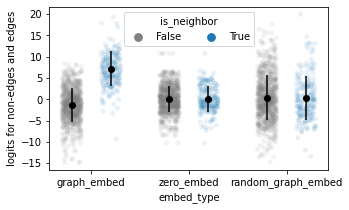

In [50]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=[5, 3])

df = df[df['node'] != df['pair_node']] # remove self-to-self node pairs
print(
    df[df['graph_embed_logit_is_topn']==True]['is_neighbor'].mean(),
    df[df['zero_embed_logit_is_topn']==True]['is_neighbor'].mean(),
    df[df['random_embed_logit_is_topn']==True]['is_neighbor'].mean()
)

# some individual samples
subsampled_df = df.sample(1000).melt(id_vars='is_neighbor', value_vars=['graph_embed_logits', 'zero_embed_logits', 'random_embed_logits'], var_name='embed_type', value_name='logits')
sns.stripplot(data=subsampled_df, x='embed_type', y='logits', hue='is_neighbor', ax=ax, dodge=True, alpha=0.1, jitter=0.2, zorder=0, palette={True: 'C0', False: 'gray'})

# mean and std
for i, embed_type in enumerate(['graph_embed_logits', 'zero_embed_logits', 'random_embed_logits']):
    edge_logits = df[(df['is_neighbor']==1)][embed_type]
    nonedge_logits = df[(df['is_neighbor']==0)][embed_type]
    ax.errorbar(x=i-0.2, y=nonedge_logits.mean(), yerr=nonedge_logits.std(), fmt='o', color='black')
    ax.errorbar(x=i+0.2, y=edge_logits.mean(), yerr=edge_logits.std(), fmt='o', color='black')
    tstat, pvalue = sp.stats.ttest_ind(edge_logits, nonedge_logits)
    print(f'{embed_type}: t={tstat:.2f}, p={pvalue:.4f}')

ax.legend(ncol=2, title='is_neighbor', loc='upper center')
ax.set_xticks(range(3))
ax.set_xticklabels(['graph_embed', 'zero_embed', 'random_graph_embed'])
ax.set_ylabel('logits for non-edges and edges')

graph embeddings

In [51]:
import sklearn.linear_model

graph_embeddings = model.transformer.graph_context_token.weight.detach().numpy()
graph_nums = np.repeat(config['dataset']['include_graphs'], repeats=10)
isomorphs = np.tile(range(config['dataset']['n_isomorph']), reps=config['dataset']['n_graph'])
graph_embeddings.shape

(500, 256)

In [59]:
# can you tell graph connectivity shared across isomorphs?
X = graph_embeddings
y = graph_nums
held_out_isomorphs = np.random.choice(np.unique(isomorphs), size=2, replace=False)
X_test = np.in1d(isomorphs, held_out_isomorphs)
X_train = ~X_test
lr = sklearn.linear_model.LogisticRegression(multi_class='multinomial')
lr.fit(X[X_train], y[X_train])
print(f'chance={1/50}, train_acc={lr.score(X[X_train], y[X_train])}, test_acc={lr.score(X[X_test], y[X_test])}')

chance=0.02, train_acc=1.0, test_acc=0.03


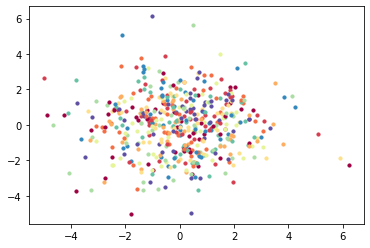

In [55]:
# do graph embeddings cluster by graph num?

import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=2)
low_dim = pca.fit_transform(graph_embeddings)

figure, ax = plt.subplots(1)
graph_num = np.repeat(config['dataset']['include_graphs'], repeats=config['dataset']['n_isomorph'])
colors = ['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd', '#5e4fa2']
for i in range(low_dim.shape[0]):
    ax.scatter(low_dim[i,0], low_dim[i,1], color=colors[graph_num[i]%10], s=10)

#### autoreg: start/goal awareness

In [16]:
import sklearn
import sklearn.linear_model
from sklearn.model_selection import KFold

def decode_cv(token_reps, X_mask, target, y_mask, layers, target_label,
              n_fold=4, downsample_to_balance_base_rate=True):

    # we have X_mask and y_mask here to allow 2d masks that selects different tokens in different seqs
    # then after taking X[X_mask] the samples are flattened out across sequences
    # the downsample_to_balance_base_rate is used to balance output classes for the decoder

    y = target[y_mask]
    selected_samples = list(range(len(y)))
    if downsample_to_balance_base_rate:
        node_class, node_count = np.unique(y, return_counts=True) # torch.unique throws weird error sometimes
        min_count = node_count.min()
        selected_samples = []
        for nc in node_class:
            select = random.sample(torch.where(y==nc)[0].tolist(), min_count)
            selected_samples.extend(select)
        selected_samples.sort()
    y = y[selected_samples].numpy()
    n = len(y)
    
    table = {'graph_context':[], 'probe_index':[], target_label:[], 'decoder_trained_on_layer':[], 'train_acc': [], 'test_acc': []}
    probe_idx = repeat(batch['index'][correct].numpy(), 'n -> n m', m=target.shape[1])
    graph_context_id = repeat(batch['graph_context'][correct].numpy(), 'n -> n m', m=target.shape[1])

    for layer in layers:
        layer_i = layers.index(layer)
        X = token_reps[:,layer_i][X_mask][selected_samples] # extracts and flattens states at the layer

        train_acc, test_acc = np.zeros(n), np.zeros(n)
        kf = KFold(n_splits=n_fold)
        for i, (train_idx, test_idx) in enumerate(kf.split(X)):

            X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
            lr = sklearn.linear_model.LogisticRegression(C=1)
            lr.fit(X_train, y_train)

            train_acc[train_idx] = lr.predict_proba(X_train).argmax(1) == y_train
            test_acc[test_idx] = lr.predict_proba(X_test).argmax(1) == y_test
    
        table['graph_context'].extend(graph_context_id[y_mask][selected_samples])
        table['probe_index'].extend(probe_idx[y_mask][selected_samples])
        table[target_label].extend(y)
        table['decoder_trained_on_layer'].extend([layer]*n)
        table['train_acc'].extend(train_acc)
        table['test_acc'].extend(test_acc)
    
    result = pd.DataFrame.from_dict(table)
    result['decoder_trained_on_layer'] = pd.Categorical(result['decoder_trained_on_layer'], categories=layers)
    return result, selected_samples

In [160]:
# get token reps and target for correct problems
if config['model']['type'] == 'autoreg':
    outpath_token_reps = token_reps[correct, :, model.transformer.sos_index:-1, :]
elif config['model']['type'] == 'masked':
    outpath_token_reps = token_reps[correct, :, -model.transformer.max_path_len:, :]

target = batch['shortest_path'][correct].detach().clone()
arch_layers = ['input'] + [f'{layertype}{l//2}' for l, layertype in enumerate(model.transformer.architecture.split('.'))]
print('total val batch: ', token_reps.shape) # (bsz, 1+n_layer, n_token, embed_dim)
print('probs w correct pred: ', outpath_token_reps.shape, target.shape)
print(arch_layers)

# some useful masks
max_pathlen = target.shape[1]
path_len = batch['path_len'][correct]
pad_mask = target == model.transformer.node_embeddings.padding_idx
start_mask = F.one_hot(torch.zeros(target.shape[0]).long(), num_classes=max_pathlen).bool()
goal_mask = F.one_hot(path_len.long() - 1, num_classes=max_pathlen).bool()

total val batch:  torch.Size([12064, 5, 12, 256])
probs w correct pred:  torch.Size([9955, 5, 8, 256]) torch.Size([9955, 8])
['input', 'a0', 'f0', 'a1', 'f1']


In [161]:
# decode start
seq_start = repeat(target[start_mask], 'b -> b n', n=max_pathlen)

pooled_result = []
for pos in range(max_pathlen):
    pos_mask = F.one_hot(pos + torch.zeros(target.shape[0]).long(), num_classes=max_pathlen).bool()
    X_mask = pos_mask & ~pad_mask
    result, x = decode_cv(token_reps=outpath_token_reps, X_mask=X_mask, target=seq_start, y_mask=X_mask, 
                          layers=arch_layers, target_label='start', n_fold=4, downsample_to_balance_base_rate=False)
    result['node_pos'] = pos
    pooled_result.append(result)
pooled_result = pd.concat(pooled_result)
pooled_result.to_csv(f'v4_decode_start_goal/{runid}_start_decoder.csv', index=False)

In [162]:
# decode goal from start to node-before-goal
seq_goal = repeat(target[goal_mask], 'b -> b n', n=max_pathlen)

pooled_result = []
for pos in range(max_pathlen-1): # the last position has to be goal or pad, excluded
    pos_mask = F.one_hot(pos + torch.zeros(target.shape[0]).long(), num_classes=max_pathlen).bool()
    X_mask = pos_mask & ~goal_mask & ~pad_mask
    result, x = decode_cv(token_reps=outpath_token_reps, X_mask=X_mask, target=seq_goal, y_mask=X_mask, 
                          layers=arch_layers, target_label='goal', n_fold=4, downsample_to_balance_base_rate=False)
    result['node_pos'] = pos
    pooled_result.append(result)
pooled_result = pd.concat(pooled_result)
pooled_result.to_csv(f'v4_decode_start_goal/{runid}_goal_decoder.csv', index=False)

In [163]:
# autoreg future decoding masks
first_intermediate = F.one_hot(torch.ones(target.shape[0]).long(), num_classes=max_pathlen).bool()
second_to_last_intermediate = F.one_hot(path_len.long() - 3, num_classes=max_pathlen).bool()
last_intermediate = F.one_hot(path_len.long() - 2, num_classes=max_pathlen).bool() # excluded so that goal awareness is not counted

# decode node after target node (excl. node-before-goal to disentalngle goal awareness)
X_mask = ~goal_mask & ~last_intermediate & ~pad_mask
y_mask = ~start_mask & ~goal_mask & ~pad_mask
result, x = decode_cv(token_reps=outpath_token_reps, X_mask=X_mask, target=target, y_mask=y_mask,
                      layers=arch_layers, target_label='next1', n_fold=4, downsample_to_balance_base_rate=False)
result.to_csv(f'v4_decode_start_goal/{runid}_next1_decoder.csv', index=False)

# two nodes after?
X_mask = ~goal_mask & ~last_intermediate & ~second_to_last_intermediate & ~pad_mask
y_mask = ~start_mask & ~first_intermediate & ~goal_mask & ~pad_mask
result, x = decode_cv(token_reps=outpath_token_reps, X_mask=X_mask, target=target, y_mask=y_mask,
                      layers=arch_layers, target_label='next2', n_fold=4, downsample_to_balance_base_rate=False)
result.to_csv(f'v4_decode_start_goal/{runid}_next2_decoder.csv', index=False)

### across multiple runs

In [4]:
sheet_id = '1nFaMtdoecqKbtQyNvZ-xFQGpV6j0nfqhxCZJMEnRs_I'
gid = '299429988'
experiment_log = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?gid={gid}&format=csv')
experiment_log['project phase'] = pd.Series(experiment_log['project phase']).fillna(method='ffill')

runs = experiment_log[experiment_log['project phase'].str.contains('graph context')]
runs = runs[['project phase', 'runid', 'model type', 'architecture', 'dataset']]

In [14]:
runs

,project phase,runid,model type,architecture,dataset
16,graph context models,hfuz3w12,random-masked,L1H1,human30
17,graph context models,2eogdrwq,random-masked,L1H1,human30
18,graph context models,258zf14v,random-masked,L1H1,human30
19,graph context models,13e7b8ig,random-masked,L1H1,human30
20,graph context models,1sbzhmry,random-masked,L1H1,random50
21,graph context models,17lwle4y,random-masked,L1H1,random50
22,graph context models,3hblx7rk,random-masked,L1H1,random50
23,graph context models,k5t3el7a,random-masked,L1H1,random50
24,graph context models,k2x2f9gm,autoreg,L2H1,human30
25,graph context models,1wczubuv,autoreg,L2H1,human30


#### graph connectivity probe test

In [39]:
runids = ['ebszm1h8', '2z0m2coa', '36awn1we', '2cn61szb'] # human30-L1H1
for runid in runids:
    print(' --- ', runid, ' --- ')
    df = graph_connectivity_probe_test(runid)
    df = df[df['node'] != df['pair_node']] # remove self-to-self node pairs
    print('  -- logit t-test --  ', end='')
    for i, embed_type in enumerate(['graph_embed_logits', 'zero_embed_logits', 'random_embed_logits']):
        edge_logits = df[(df['is_neighbor']==1)][embed_type]
        nonedge_logits = df[(df['is_neighbor']==0)][embed_type]
        tstat, pvalue = sp.stats.ttest_ind(edge_logits, nonedge_logits)
        print(embed_type, ':', 't=%.2f'%tstat+','+'p=%.4f'%pvalue, end=' | ')
    print('\n  -- topn logit match --  ', end='')
    for i, logit_topn in enumerate(['graph_embed_logit_is_topn', 'zero_embed_logit_is_topn', 'random_embed_logit_is_topn']):
        acc = df[df[logit_topn]==True]['is_neighbor'].mean()
        print(logit_topn, ':', 'match_acc=%.2f'%acc, end=' | ')
    print()

 ---  ebszm1h8  --- 
  -- logit t-test --  graph_embed_logits : t=38.42,p=0.0000 | zero_embed_logits : t=1.13,p=0.2575 | random_embed_logits : t=0.79,p=0.4270 | 
  -- topn logit match --  graph_embed_logit_is_topn : match_acc=0.62 | zero_embed_logit_is_topn : match_acc=0.46 | random_embed_logit_is_topn : match_acc=0.46 | 
 ---  2z0m2coa  --- 
  -- logit t-test --  graph_embed_logits : t=38.03,p=0.0000 | zero_embed_logits : t=2.59,p=0.0095 | random_embed_logits : t=2.50,p=0.0123 | 
  -- topn logit match --  graph_embed_logit_is_topn : match_acc=0.59 | zero_embed_logit_is_topn : match_acc=0.47 | random_embed_logit_is_topn : match_acc=0.47 | 
 ---  36awn1we  --- 
  -- logit t-test --  graph_embed_logits : t=37.06,p=0.0000 | zero_embed_logits : t=0.44,p=0.6618 | random_embed_logits : t=-0.15,p=0.8836 | 
  -- topn logit match --  graph_embed_logit_is_topn : match_acc=0.59 | zero_embed_logit_is_topn : match_acc=0.45 | random_embed_logit_is_topn : match_acc=0.45 | 
 ---  2cn61szb  --- 
  -- l

#### decode start and goal

In [5]:
# piece together multi-seed results
dataset = 'random50'
model_type = 'autoreg'
dfs = []
for runid in runs[(runs['dataset']==dataset)&(runs['model type']==model_type)]['runid'].values:
    df = pd.read_csv(f'v4_decode_start_goal/{runid}_start_decoder.csv')
    df['runid'] = runid
    dfs.append(df)
result = pd.concat(dfs)
result['decoder_trained_on_layer'] = pd.Categorical(result['decoder_trained_on_layer'], categories=['input', 'a0', 'f0', 'a1', 'f1'])

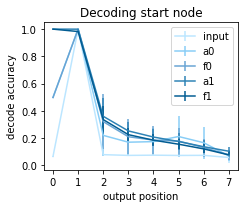

In [ ]:
# start/goal decoding

plot_data = result.groupby(['runid', 'decoder_trained_on_layer', 'node_pos']).mean()
plot_data = plot_data.groupby(['decoder_trained_on_layer', 'node_pos']).agg([np.mean, np.std]).reset_index()

fig, ax = plt.subplots(1, figsize=[3.5,3])
colors = {'input':'#bce6ff', 'a0':'#88cdf6', 'f0':'#68A4D4', 'a1':'#2d82b5', 'f1':'#015c92'}

for i, layer in enumerate(['input', 'a0', 'f0', 'a1', 'f1']):
    x = plot_data[plot_data['decoder_trained_on_layer']==layer]
    xs = x['node_pos'].values
    ys = x['test_acc']['mean'].values
    yerrs = x['test_acc']['std'].values
    ax.errorbar(xs, ys, yerr=yerrs, label=layer, color=colors[layer])

ax.set_xticks(range(8))
ax.set_title('Decoding start node')
ax.legend(ncol=1)
ax.set_xlabel('output position')
ax.set_ylabel('decode accuracy')

fig.tight_layout()
# fig.savefig(f'../figure/plos/startdec_random50_graphcontext_autoreg.png', dpi=300)

In [74]:
# piece together multi-seed results
dataset = 'random50'
model_type = 'autoreg'
dfs = []
for runid in runs[(runs['dataset']==dataset)&(runs['model type']==model_type)]['runid'].values:
    df = pd.read_csv(f'v4_decode_start_goal/{runid}_next2_decoder.csv')
    df['runid'] = runid
    dfs.append(df)
result = pd.concat(dfs)
result['decoder_trained_on_layer'] = pd.Categorical(result['decoder_trained_on_layer'], categories=['input', 'a0', 'f0', 'a1', 'f1'])

In [75]:
plot_data = result.groupby(['runid', 'decoder_trained_on_layer']).mean()
plot_data = plot_data.groupby(['decoder_trained_on_layer']).agg([np.mean, np.std]).reset_index()
# next1_ys = plot_data['test_acc']['mean'].values
# next1_yerrs = plot_data['test_acc']['std'].values
next2_ys = plot_data['test_acc']['mean'].values
next2_yerrs = plot_data['test_acc']['std'].values

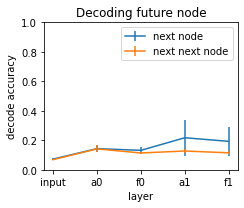

In [ ]:
# autoreg next1/next2 decoding

plot_data = result.groupby(['runid', 'decoder_trained_on_layer']).mean()
plot_data = plot_data.groupby(['decoder_trained_on_layer']).agg([np.mean, np.std]).reset_index()

fig, ax = plt.subplots(1, figsize=[3.5,3])
xs = plot_data['decoder_trained_on_layer'].values
ax.errorbar(xs, next1_ys, yerr=next1_yerrs, color='C0', label='next node')
ax.errorbar(xs, next2_ys, yerr=next2_yerrs, color='C1', label='next next node')

ax.legend()
ax.set_xlabel('layer')
ax.set_ylabel('decode accuracy')
ax.set_title('Decoding future node')
ax.set_ylim([0,1])

fig.tight_layout()
# fig.savefig(f'../figure/plos/nextdec_random50_graphcontext_autoreg.png', dpi=300)